
# 🚢 Prédiction de survie – Titanic avec scikit-learn & TensorFlow

Ce notebook explore la prédiction de la variable `Survived` du célèbre jeu de données Titanic.

## Objectifs :
- Charger et nettoyer les données Titanic  
- Préparer les données pour l'entraînement (imputation, encodage, normalisation)  
- Comparer deux modèles de classification :  
  - 🌲 RandomForestClassifier (scikit-learn)  
  - 🔬 KerasClassifier (réseau de neurones simple avec TensorFlow)  
- Évaluer les performances (accuracy, F1-score, matrice de confusion)  
- Visualiser les résultats  

🔗 Données d’origine : [Kaggle Titanic Dataset](https://www.kaggle.com/c/titanic/data)

*Auteur : Copilot pour Philippe 💼*


In [4]:
!pip install scikeras



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier


In [6]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df = df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Survived"]]
df.dropna(subset=["Embarked"], inplace=True)  # Supprime les lignes avec Embarked manquant
X = df.drop("Survived", axis=1)
y = df["Survived"]

numeric_features = ["Age", "Fare", "SibSp", "Parch"]
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_features = ["Sex", "Embarked", "Pclass"]
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])


In [10]:
# Vérifie qu'il n'y a plus de NaN après transformation
X_transformed = preprocessor.fit_transform(X)
print(np.isnan(X_transformed).sum())  # doit afficher 0


0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       109
           1       0.68      0.75      0.71        69

    accuracy                           0.76       178
   macro avg       0.75      0.76      0.76       178
weighted avg       0.77      0.76      0.77       178



In [12]:
def build_keras_model(input_dim):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [13]:
keras_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", KerasClassifier(model=build_keras_model, verbose=0, epochs=30, input_dim=preprocessor.fit_transform(X_train).shape[1]))
])

keras_pipeline.fit(X_train, y_train)
y_pred_keras = keras_pipeline.predict(X_test)

print("KerasClassifier Report:")
print(classification_report(y_test, y_pred_keras))


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-25 14:01:53.993283: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


KerasClassifier Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       109
           1       0.73      0.75      0.74        69

    accuracy                           0.80       178
   macro avg       0.79      0.79      0.79       178
weighted avg       0.80      0.80      0.80       178



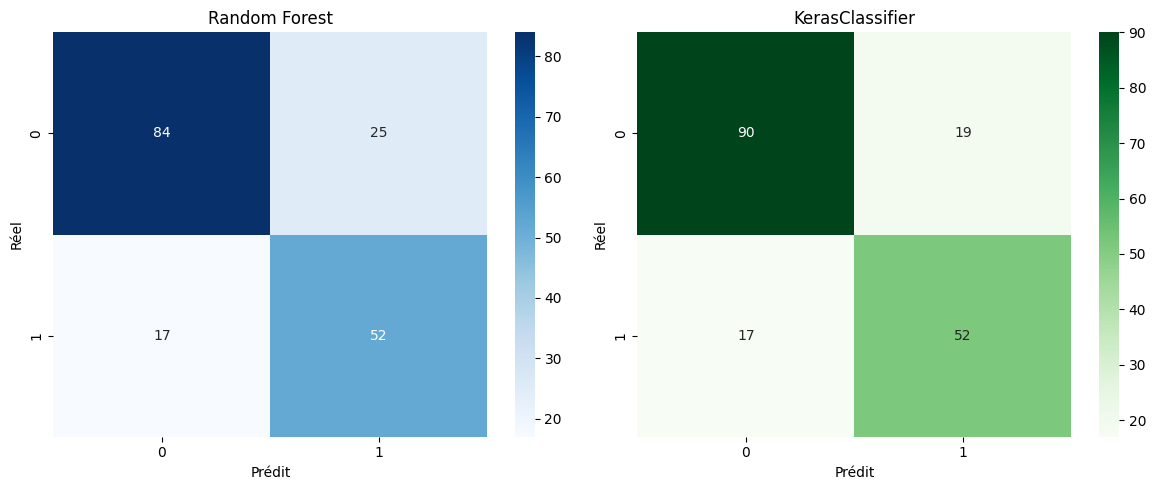

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=ax[0], cmap="Blues")
ax[0].set_title("Random Forest")

sns.heatmap(confusion_matrix(y_test, y_pred_keras), annot=True, fmt='d', ax=ax[1], cmap="Greens")
ax[1].set_title("KerasClassifier")

for a in ax:
    a.set_xlabel("Prédit")
    a.set_ylabel("Réel")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


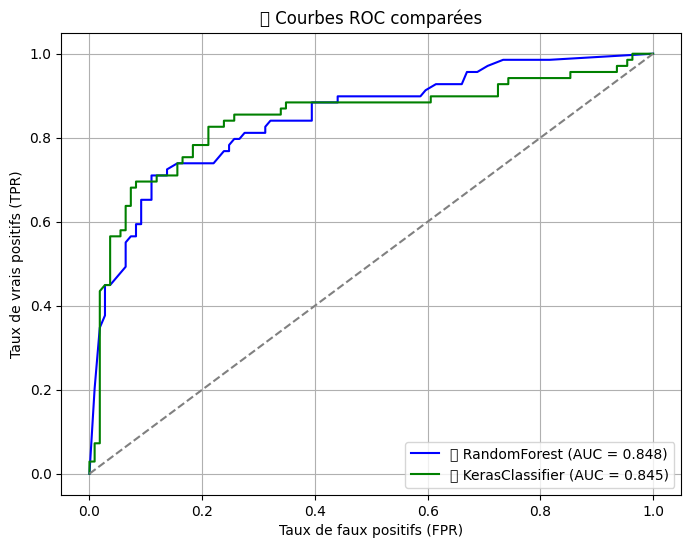

In [16]:
from sklearn.metrics import roc_curve, auc

# Prédictions probabilistes
proba_rf = rf_model.predict_proba(X_test)[:, 1]
proba_keras = keras_pipeline.predict_proba(X_test)[:, 1]

# Courbes ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, proba_rf)
fpr_keras, tpr_keras, _ = roc_curve(y_test, proba_keras)

# AUC
auc_rf = auc(fpr_rf, tpr_rf)
auc_keras = auc(fpr_keras, tpr_keras)

# Tracé
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'🌲 RandomForest (AUC = {auc_rf:.3f})', color='blue')
plt.plot(fpr_keras, tpr_keras, label=f'🔬 KerasClassifier (AUC = {auc_keras:.3f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("🎯 Courbes ROC comparées")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
